# Deep Learning

## We'll be using sklearning and tensorflow.

### Goals with DL:
 The strategy is to apply DL in order to predict a song's popularity. The threshold to make a song popular is a popularity score above 60. Then a 1 equals popular and a 0 not-popular.

### Preprocessing:

 Before starting to apply any DL methodologies, we first had to prepare our dataset.
 Removing columns with unique for the songs' information would not bring any purpose to predicting the its popularity. Therefore, information such as Song name, Playlist name, URI, and more, were removed.

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [57]:
# Getting the CSV file with all the information merged together
ml_df = pd.read_csv('Resources/all_data.csv', index_col=False)

# Every song has a unique Track_URI. So, using drop_duplicates ensures all song tracks are unique.
unique_ml_df = ml_df.drop_duplicates(subset=['track_uri'])

# Dropping columns which is specific for each song (like name and uri)
unique_ml_df = unique_ml_df.drop(columns=['Unnamed: 0', 'followers', 'songs',
                            'playlist_uri','track_uri','artist_name',
                            'song_name', 'analysis_url', 'id','uri',
                            'time_signature', 'playlist_name','track_href',
                            'type', 'mode', 'genre_2' ])

In [58]:
# merge_df = unique_ml_df.drop(columns=['genre_1'])


### Bucketing
Before we can convert "genre" into a one-hot encoding, we need to make sure that there are not too many unique values that would cause our dataset to become too wide.

Indie                744
Rock                 715
Pop                  690
Electronic           636
Jazz                 515
Instrumental         486
Blues                409
Latin                375
Singer-Songwriter    337
R&B                  336
Country              333
Metal                317
Rap                  283
Christian            177
Classical            153
K-Pop                150
Alternative          100
Name: genre_1, dtype: int64


<AxesSubplot:ylabel='Density'>

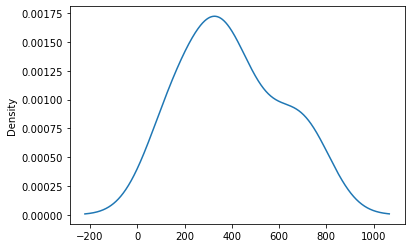

In [74]:
#Getting the genre's categories and its distribution

genre_type_count = unique_ml_df.genre_1.value_counts()
print(genre_type_count)
genre_type_count.plot.density()

In [75]:
# Selecting which values to replace

replace_genre = list(genre_type_count[genre_type_count < 300].index)

for song in replace_genre:
    unique_ml_df.genre_1 = unique_ml_df.genre_1.replace(song,'Other')
    
print(unique_ml_df.genre_1.value_counts())


Other                863
Indie                744
Rock                 715
Pop                  690
Electronic           636
Jazz                 515
Instrumental         486
Blues                409
Latin                375
Singer-Songwriter    337
R&B                  336
Country              333
Metal                317
Name: genre_1, dtype: int64


In [76]:
# Transposing the genre variability (trying with both genres first, than with only genre2)
# OneHoteEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce an encoded DF

encode_df = pd.DataFrame(enc.fit_transform(unique_ml_df.genre_1.values.reshape(-1,1)))
encode_df.columns = enc.get_feature_names(['genre_1'])

/Users/bneves/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [77]:
# Merging genre1 then genre2 and drop originals in the process
unique_ml_df = unique_ml_df.reset_index(drop=True)
merge_df = unique_ml_df.merge(encode_df,left_index=True, right_index=True)

merge_df = merge_df.drop(columns=['genre_1'])

In [78]:
# Splitting the preprocessed data into features and targets

X = merge_df.drop(columns=['popular', 'popularity'])
y = merge_df['popular'].values

# Training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y) # Test size is 25%

In [79]:
# Scaling the dataset
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [83]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# Adopting a ratio to generate neurons according to the number of features (columns) given.

number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = number_input_features//0.75
hidden_nodes_layer2 = number_input_features//1.20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='tanh'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compiling the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Check the strucutre of the model
nn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_36 (Dense)             (None, 20)                660       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 21        
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=120)

Epoch 1/120
159/159 [==============================] - 0s 455us/step - loss: 0.6354 - accuracy: 0.6385
Epoch 2/120
159/159 [==============================] - 0s 393us/step - loss: 0.5140 - accuracy: 0.7310
Epoch 3/120
159/159 [==============================] - 0s 391us/step - loss: 0.4823 - accuracy: 0.7552
Epoch 4/120
159/159 [==============================] - 0s 394us/step - loss: 0.4722 - accuracy: 0.7663
Epoch 5/120
159/159 [==============================] - 0s 406us/step - loss: 0.4638 - accuracy: 0.7634
Epoch 6/120
159/159 [==============================] - 0s 415us/step - loss: 0.4578 - accuracy: 0.7652
Epoch 7/120
159/159 [==============================] - 0s 406us/step - loss: 0.4551 - accuracy: 0.7650
Epoch 8/120
159/159 [==============================] - 0s 404us/step - loss: 0.4596 - accuracy: 0.7712
Epoch 9/120
159/159 [==============================] - 0s 409us/step - loss: 0.4644 - accuracy: 0.7613
Epoch 10/120
159/159 [==============================] - 0s 407us/step - l

159/159 [==============================] - 0s 405us/step - loss: 0.3880 - accuracy: 0.8167
Epoch 80/120
159/159 [==============================] - 0s 401us/step - loss: 0.3756 - accuracy: 0.8199
Epoch 81/120
159/159 [==============================] - 0s 398us/step - loss: 0.3772 - accuracy: 0.8203
Epoch 82/120
159/159 [==============================] - 0s 398us/step - loss: 0.3650 - accuracy: 0.8309
Epoch 83/120
159/159 [==============================] - 0s 387us/step - loss: 0.3727 - accuracy: 0.8257
Epoch 84/120
159/159 [==============================] - 0s 389us/step - loss: 0.3920 - accuracy: 0.8098
Epoch 85/120
159/159 [==============================] - 0s 392us/step - loss: 0.3847 - accuracy: 0.8176
Epoch 86/120
159/159 [==============================] - 0s 391us/step - loss: 0.3744 - accuracy: 0.8302
Epoch 87/120
159/159 [==============================] - 0s 389us/step - loss: 0.3808 - accuracy: 0.8262
Epoch 88/120
159/159 [==============================] - 0s 395us/step - loss:

In [85]:
# Evaluating the model with our test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

53/53 - 0s - loss: 0.5670 - accuracy: 0.7217
Loss: 0.5669702291488647, Accuracy: 0.7217288613319397
